# Calculating Hedge Ratios for Swap Curve and Fly Trades
- Using a practical example from JPM Rates Strategy
- For the math background see [calculating_cash_hedge_ratios.ipynb](https://github.com/yieldcurvemonkey/Curvy-CUSIPs/blob/main/notebooks/calculating_cash_hedge_ratios.ipynb)

In [1]:
import sys
sys.path.append("../")

In [132]:
import pandas as pd
from datetime import datetime 
from pandas.tseries.offsets import CustomBusinessDay 
from pandas.tseries.holiday import USFederalHolidayCalendar

from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.S490Swaps import S490Swaps
from CurvyCUSIPs.utils.regression_utils import run_basic_linear_regression_df, run_multiple_linear_regression_df, plot_residuals_timeseries
import CurvyCUSIPs.HedgeHog.swaps as hh_swaps

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('ggplot')
params = {'legend.fontsize': 'large',
        'figure.figsize': (12, 8),
        'axes.labelsize': 'large',
        'axes.titlesize':'large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
curve_data_fetcher = CurveDataFetcher()

In [43]:
s490_swaps = S490Swaps(s490_curve_db_path=r"..\db\nyclose_sofr_ois", curve_data_fetcher=curve_data_fetcher)

start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 20)
bdates = pd.date_range(start=start_date, end=end_date, freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))

In [116]:
fwd_tenors = ["1M", "6M"]
fwd_grid_dict, ql_curves = s490_swaps.s490_nyclose_fwd_curve_matrices(
    start_date=start_date,
    end_date=end_date,
    ql_piecewise_method="logLinearDiscount",
    fwd_tenors=fwd_tenors,
)

Building Implied Fwd Curves...: 100%|██████████| 245/245 [00:00<00:00, 248.25it/s]


## Positioning for RV and Carry Trades:

In the last note of 2024, Srini Ramaswamy and team writes, 

```
What does this mean for yield curve strategy? At least in the short run, with the Fed once more close to being on hold, this is likely to bring about conditions that are favorable for yield curve carry trades and relative value convergence trades. It also creates conditions that are favorable for conditional bullish trades (given how little easing is priced in), if they can be constructed efficiently. To be sure, this week's FOMC meeting likely augurs a Fed that is once more focused on inflation risks and therefore less inclined to cut rates, that can change if labor market data were to weaken.
```

...

```
One way to position for relative value convergence that is currently attractive is to initiate 10s/30s swap curve steepeners paired with a small short in 2s. As seen in Figure 5, the 10s/30s curve is well correlated with 2Y swap yields, but is slightly too flat relative to this relationship (Figure 5). Carry on the package is close to zero. Thus, this package offers an attractive way to position for relative value convergence in the near term when the Fed is likely to be on hold, and we recommend this trade (see Trade recommendations).
```

...

```
Initiate 10s/30s swap curve steepeners paired with a 16% weighted shorts in 2s The 10s/30s curve is well correlated with 2Y swap yields, but is slightly too flat relative to this relationship. Carry on this package is close to zero, and this trade offers an attractive way to position for relative value convergence in the near term when the Fed is likely to be on hold. -Receive-fixed in $100mn notional of a 01/20/25x10Y SOFR swap at a yield of 4.03% (PVBP: $815.2/bp per mn notional). Pay-fixed in $46.9mn notional of a 01/20/25x30Y SOFR swap at a yield of 3.866% (PVBP: $1738.5/bp per mn notional). Pay-fixed in $66.3mn notional of a 01/20/25x2Y SOFR swap at a yield of 4.116% (PVBP: $196.7/bp per mn notional). This trade uses risk weights of 1.0/-1.0/-0.16 on the 1Mx10Y/1Mx30Y/1Mx2Y swaps respectively. This trade is being initiated at a yield spread of 49.5bp
```

...

```
Buy the belly of a 6M forward 5s/10s/30s swap yield curve butterfly (-0.5:1.0:-0.5 weighted) The current yield spread corresponding to this butterfly is over 2bp greater than its 6m average. This yield spread has been largely mean reverting, carry is roughly flat, and the current levels make for an attractive entry point. -Pay-fixed in $93.7mn notional of a 06/20/25x5Y SOFR swap at a yield of 4.009% (PVBP: $427.0/bp per mn notional). Receive-fixed in $100mn notional of a 06/20/25x10Y SOFR swap at a yield of 4.016% (PVBP: $799.8/bp per mn notional). Pay-fixed in $23.4mn notional of a 06/20/25x30Y SOFR swap at a yield of 3.845% (PVBP: $1708.0/bp per mn notional). This trade uses risk weights of -0.5/1.0/-0.5 on the 6Mx5Y/6Mx10Y/6Mx30Y swaps respectively. This trade is being initiated at a yield spread of -8.9bp
```

![womp womp](../dump/Screenshot%202025-01-09%20093700.png)

![womp womp](../dump/Screenshot%202025-01-09%20103707.png)

Let's see if we can recreate this with `Curvy-CUSIPs`

## The 10s/30s swap curve has been highly correlated to front end rates but currently looks too flat to this relationship

In [117]:
timeseries_df = s490_swaps.timeseries_builder(
    fwd_dict_df=fwd_grid_dict,
    cols=["1M Fwd 2Y", "1M Fwd 10Y", "1M Fwd 30Y", "1M Fwd 10Y-1M Fwd 30Y"],
    start_date=start_date,
    end_date=end_date,
    tenor_is_df_index=True,
    scale_curve=False,
)
timeseries_df

BUILDING OIS SWAP TIMESERIES DF...: 100%|██████████| 245/245 [00:00<00:00, 611.51it/s]


,Date,1M Fwd 2Y,1M Fwd 10Y,1M Fwd 30Y,1M Fwd 10Y-1M Fwd 30Y
0,2024-01-02,4.030491,3.478780,3.250748,-0.228032
1,2024-01-03,4.036088,3.489471,3.284015,-0.205456
2,2024-01-04,4.118281,3.581933,3.363341,-0.218592
3,2024-01-05,4.118588,3.624738,3.404578,-0.220160
4,2024-01-08,4.115083,3.633807,3.409503,-0.224304
...,...,...,...,...,...
239,2024-12-16,4.035658,3.908337,3.684002,-0.224335
240,2024-12-17,4.037705,3.898429,3.644064,-0.254365
241,2024-12-18,4.164224,3.994912,3.715700,-0.279212
242,2024-12-19,4.141275,4.084253,3.776982,-0.307271


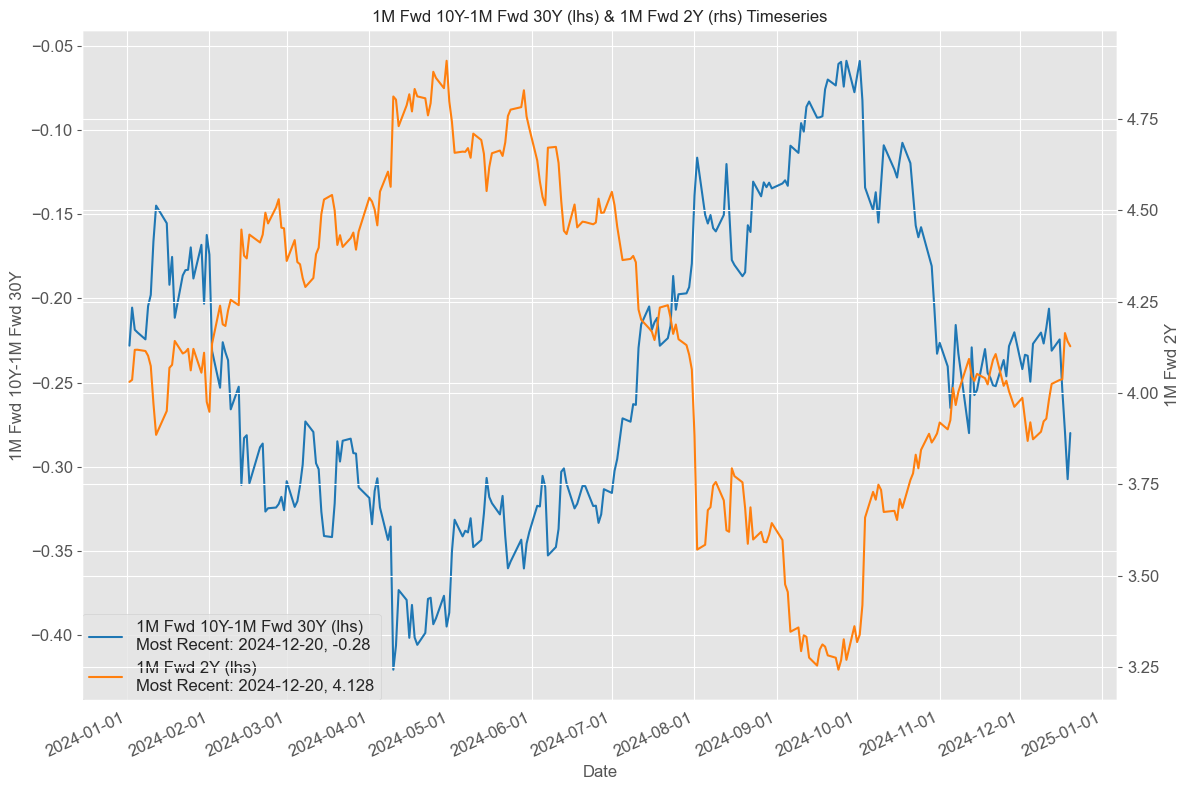

In [118]:
s490_swaps._general_df_plotter(df=timeseries_df, cols_to_plot=["1M Fwd 10Y-1M Fwd 30Y"], cols_to_plot_raxis=["1M Fwd 2Y"])

                              OLS Regression Results                             
Dep. Variable:     1M Fwd 10Y-1M Fwd 30Y   R-squared:                       0.924
Model:                               OLS   Adj. R-squared:                  0.924
Method:                    Least Squares   F-statistic:                     2952.
Date:                   Thu, 09 Jan 2025   Prob (F-statistic):          1.39e-137
Time:                           12:42:35   Log-Likelihood:                 558.83
No. Observations:                    244   AIC:                            -1114.
Df Residuals:                        242   BIC:                            -1107.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5844 

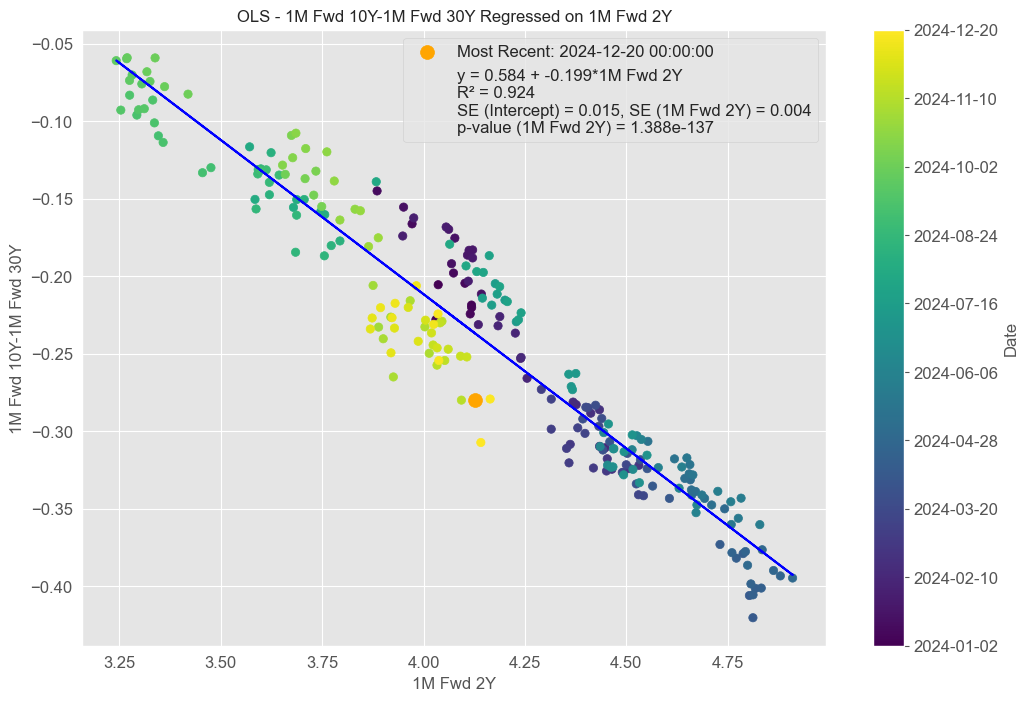

In [119]:
strat_rr = run_basic_linear_regression_df(df=timeseries_df, x_col="1M Fwd 2Y", y_col="1M Fwd 10Y-1M Fwd 30Y", plot_most_recent=True, date_color_bar=True)

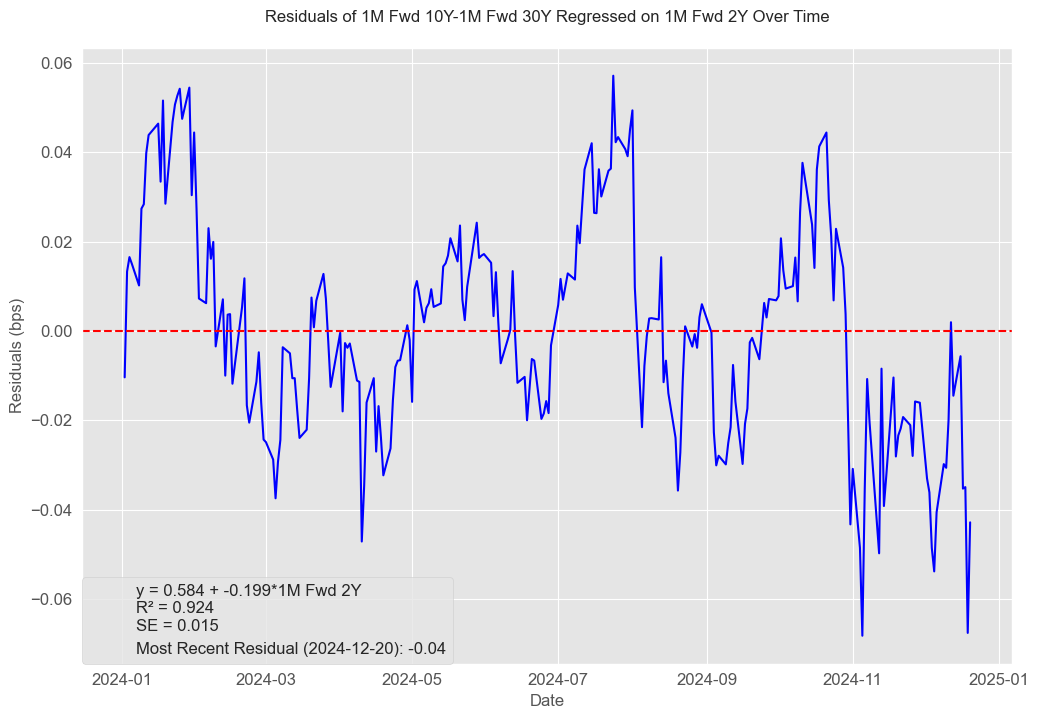

In [120]:
plot_residuals_timeseries(df=timeseries_df, results=strat_rr)

## Beta mismatch:
- Somewhat expected given that we are scraping together SOFR OIS data from the Eris FTP
- JPM's $-0.1656$ $\beta$ for 1m Fwd 10s30s vs our $-0.199$ $\beta$ result
- Close enough for me lol! See that this is a magnitude/scaling problem rather than a relationship/trend problem

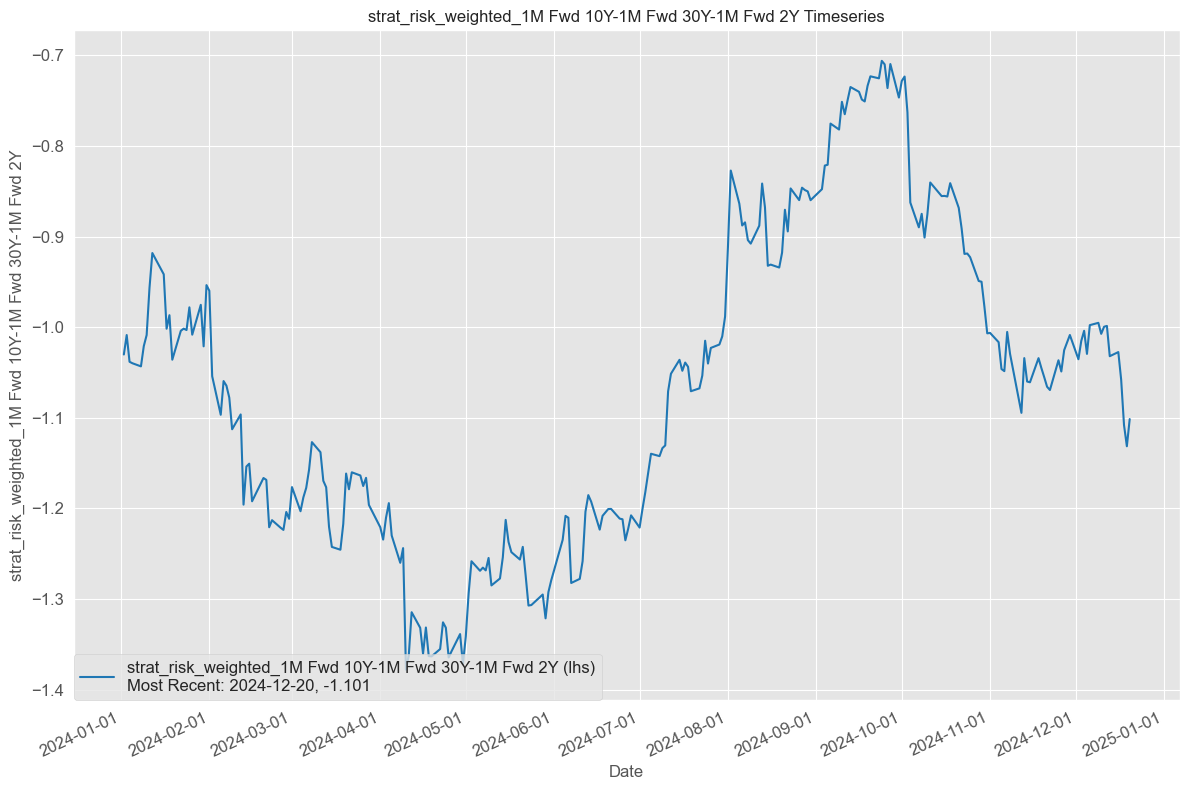

In [121]:
timeseries_df["strat_risk_weighted_1M Fwd 10Y-1M Fwd 30Y-1M Fwd 2Y"] = timeseries_df["1M Fwd 10Y-1M Fwd 30Y"] + timeseries_df["1M Fwd 2Y"] * strat_rr.params["1M Fwd 2Y"]
s490_swaps._general_df_plotter(df=timeseries_df, cols_to_plot=["strat_risk_weighted_1M Fwd 10Y-1M Fwd 30Y-1M Fwd 2Y"])

                            OLS Regression Results                            
Dep. Variable:             1M Fwd 10Y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     2107.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):          4.03e-121
Time:                        12:42:38   Log-Likelihood:                 625.61
No. Observations:                 243   AIC:                            -1247.
Df Residuals:                     241   BIC:                            -1240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.414e-05      0.001      0.012      0.9

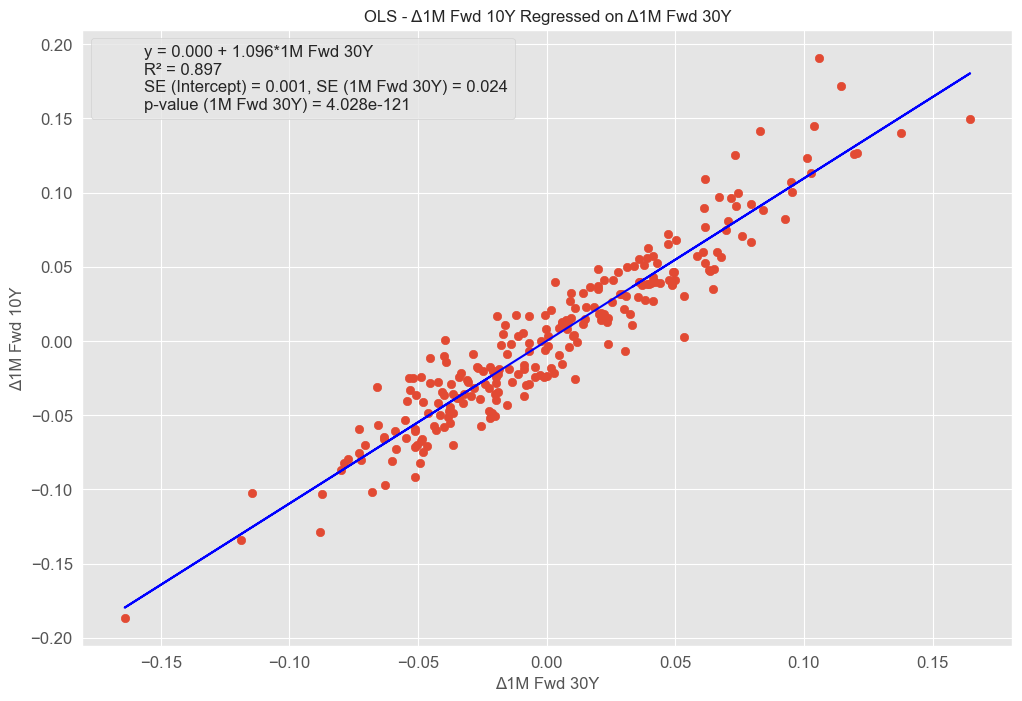

In [122]:
curve_rr = run_basic_linear_regression_df(df=timeseries_df, x_col="1M Fwd 30Y", y_col="1M Fwd 10Y", on_diff=True)

## Hedge Ratios for 1m fwd 10s30s Curve

In [123]:
front_leg = "1M Fwd 10Y" 
back_leg = "1M Fwd 30Y" 

curve_hr_dict = hh_swaps.dv01_neutral_curve_hedge_ratio(
    front_leg_swap=hh_swaps.SwapLeg(
        original_tenor=front_leg, original_fixed_rate=timeseries_df[front_leg].iloc[-1]/100, trade_date=end_date, weighting=1, 
    ),
    back_leg_swap=hh_swaps.SwapLeg(
        original_tenor=back_leg, original_fixed_rate=timeseries_df[back_leg].iloc[-1]/100, trade_date=end_date, weighting=-1, 
    ),
    ql_curve=ql_curves[end_date],
    ql_yts=s490_swaps._ql_yts,
    ql_sofr=s490_swaps._ql_sofr,
    front_leg_notional=100_000_000,
    # beta_adjustment_wrt_back_leg=curve_rr.params[back_leg],
)

curve_hr_dict

BPV Neutral Hedge Ratio: -2.1336465599315804
1M Fwd 10Y: Notional = 100_000_000.000, PVBP = -81_495.592
1M Fwd 30Y: Notional = -46_868_118.590, PVBP = 81_495.592
Net Notional: 53_131_881.410
BVP Neutral PVBP: 81_495.592


{'current_curve_bps': np.float64(-27.98990356329245),
 'current_curve_pvbp': np.float64(81495.59180144078),
 'bpv_neutral_curve_bps': np.float64(-27.98990356329245),
 'bpv_neutral_curve_pvbp': np.float64(81495.59180144078),
 '1M_carry_and_roll_bps_running': 0.3465608149558902,
 '1M_carry_and_roll_bps_running_beta_weighted': None,
 '2M_carry_and_roll_bps_running': 0.46231861490719806,
 '2M_carry_and_roll_bps_running_beta_weighted': None,
 '3M_carry_and_roll_bps_running': 0.5885111821627573,
 '3M_carry_and_roll_bps_running_beta_weighted': None,
 '6M_carry_and_roll_bps_running': 1.5309541027247464,
 '6M_carry_and_roll_bps_running_beta_weighted': None,
 'total_trade_notional': 53131881.41000883,
 'front_leg': {'current_yield': np.float64(0.04035480662601798),
  'current_weighted_yield': np.float64(0.04035480662601798),
  'hr': -2.1336465599315804,
  'bpv': -2.1336465599315804,
  'notional': 100000000,
  'pvbp_per_mm': -814.9559180144078,
  'pvbp_leg': -81495.59180144078,
  'bpv_bps_running

## Book metrics for 1m Fwd 10s30s curve with 16% risk short in 1m Fwd 2s

In [124]:
twos = "1M Fwd 2Y"

book_metrics_dict = hh_swaps.book_metrics(
    swap_portfolio=[
        hh_swaps.SwapLeg(
            original_tenor=front_leg, original_fixed_rate=timeseries_df[front_leg].iloc[-1]/100, trade_date=end_date, weighting=1, key=front_leg
        ),
        hh_swaps.SwapLeg(
            original_tenor=back_leg, original_fixed_rate=timeseries_df[back_leg].iloc[-1]/100, trade_date=end_date, weighting=-1, key=back_leg
        ),
        hh_swaps.SwapLeg(
            original_tenor=twos, original_fixed_rate=timeseries_df[twos].iloc[-1]/100, trade_date=end_date, weighting=strat_rr.params["1M Fwd 2Y"], key=twos
        ),
    ],
    ql_curve=ql_curves[end_date],
    ql_yts=s490_swaps._ql_yts,
    ql_sofr=s490_swaps._ql_sofr,
    agg_c_and_r_results=True
)

book_metrics_dict

{'total_carry_and_roll':       Total C+R (bps)
 30D          1.118468
 60D          1.549574
 90D          2.001517
 180D         2.910378
 360D         6.704255,
 'bps_running': {'1M Fwd 10Y': {'roll': {'30D': 0.10160996736389982,
    '60D': 0.18211547301076603,
    '90D': 0.2469478951275944,
    '180D': 0.341908317087955,
    '360D': 0.04762942487517019},
   'carry': {'30D': -0.7811213488997937,
    '60D': -1.3132367678137662,
    '90D': -1.8137251424750478,
    '180D': -2.171629119560106,
    '360D': -1.2490026966727878}},
  '1M Fwd 30Y': {'roll': {'30D': -0.2086283881332779,
    '60D': -0.3023484088933437,
    '90D': -0.4011326506419416,
    '180D': -0.7763906860269731,
    '360D': -1.7301787759541747},
   'carry': {'30D': -0.8174438083585062,
    '60D': -1.2910915008168544,
    '90D': -1.754155778868269,
    '180D': -2.5842842191699242,
    '360D': -3.652072477321328}},
  '1M Fwd 2Y': {'roll': {'30D': -0.4260523038509406,
    '60D': 0.32722026224507594,
    '90D': 1.06164284844015

Need to pay fixed in 85mm notional of a 1m2y using our empirical beta

In [125]:
required_pay_fixed_twos_pvbp = curve_hr_dict["bpv_neutral_curve_pvbp"] * strat_rr.params["1M Fwd 2Y"]
required_pay_fixed_twos_notional = required_pay_fixed_twos_pvbp /  book_metrics_dict["book"]["1M Fwd 2Y"].fixedLegBPS()
required_pay_fixed_twos_notional

np.float64(-85311830.68381245)

Need to pay fixed in 68mm notional of a 1m2y using JPM's -16 beta

In [126]:
required_pay_fixed_twos_pvbp = curve_hr_dict["bpv_neutral_curve_pvbp"] * -0.16 
required_pay_fixed_twos_notional = required_pay_fixed_twos_pvbp /  book_metrics_dict["book"]["1M Fwd 2Y"].fixedLegBPS()
required_pay_fixed_twos_notional

np.float64(-68594104.78157292)

## Or, we can just treat this as a custom risk weighted fly:

In [128]:
bfly_hr_dict = hh_swaps.dv01_neutral_butterfly_hedge_ratio(
    front_leg_swap=hh_swaps.SwapLeg(
        original_tenor=front_leg,
        original_fixed_rate=timeseries_df[front_leg].iloc[-1] / 100,
        trade_date=end_date,
        weighting=1,
    ),
    belly_swap=hh_swaps.SwapLeg(
        original_tenor=back_leg,
        original_fixed_rate=timeseries_df[back_leg].iloc[-1] / 100,
        trade_date=end_date,
        weighting=-1,
    ),
    back_leg_swap=hh_swaps.SwapLeg(
        original_tenor=twos, original_fixed_rate=timeseries_df[twos].iloc[-1] / 100, trade_date=end_date, weighting=strat_rr.params["1M Fwd 2Y"], key=twos
    ),
    ql_curve=ql_curves[end_date],
    ql_yts=s490_swaps._ql_yts,
    ql_sofr=s490_swaps._ql_sofr,
    front_wing_notional=100_000_000,
)

bfly_hr_dict

BPV Neutral Hedge Ratio:
{
    "front_wing_hr": 2.1336465599315804,
    "belly_hr": -1,
    "back_wing_hr": -1.8202529405998185
}
1M Fwd 10Y: Fixed Notional = 100_000_000.000, PVBP = 81_495.592
1M Fwd 30Y: Fixed Notional = -46_868_118.590, PVBP = -81_495.592
1M Fwd 2Y: Fixed Notional = -85_311_830.684, PVBP = -16_217.226
Net Fixed Notional: -32_179_949.274
BPV Neutral Fly PVBP: 3_227.149
3M bps Running Carry & Roll: 2.002 bps


{'is_long': np.float64(1.0),
 'risk_weights': [1, -1, np.float64(-0.1989951316206534)],
 'current_fly_bps': np.float64(-54.1564580567438),
 'current_fly_pvbp': np.float64(3227.1490257809187),
 'bpv_neutral_fly_bps': np.float64(-32.618813437438334),
 'bpv_neutral_fly_pvbp': np.float64(40747.79590072039),
 '1M_carry_and_roll_bps_running': np.float64(1.1184678408954145),
 '1M_carry_and_roll_bps_running_beta_weigted': None,
 '2M_carry_and_roll_bps_running': np.float64(1.5495741283616211),
 '2M_carry_and_roll_bps_running_beta_weigted': None,
 '3M_carry_and_roll_bps_running': np.float64(2.001516546529299),
 '3M_carry_and_roll_bps_running_beta_weigted': None,
 '6M_carry_and_roll_bps_running': np.float64(2.910378267434449),
 '6M_carry_and_roll_bps_running_beta_weigted': None,
 'total_trade_notional': np.float64(-32179949.273803607),
 'front_wing': {'current_yield': np.float64(0.04035480662601798),
  'current_weighted_yield': np.float64(0.04035480662601798),
  'hr': np.float64(2.133646559931580

## Required notional amount to pay fixed in 2s is a bit different given our beta mismatch, here's what it looks like with the same $\beta$ of -0.16

In [129]:
hh_swaps.dv01_neutral_butterfly_hedge_ratio(
    front_leg_swap=hh_swaps.SwapLeg(
        original_tenor=front_leg,
        original_fixed_rate=timeseries_df[front_leg].iloc[-1] / 100,
        trade_date=end_date,
        weighting=1,
    ),
    belly_swap=hh_swaps.SwapLeg(
        original_tenor=back_leg,
        original_fixed_rate=timeseries_df[back_leg].iloc[-1] / 100,
        trade_date=end_date,
        weighting=-1,
    ),
    back_leg_swap=hh_swaps.SwapLeg(
        original_tenor=twos, original_fixed_rate=timeseries_df[twos].iloc[-1] / 100, trade_date=end_date, weighting=-0.16, key=twos
    ),
    ql_curve=ql_curves[end_date],
    ql_yts=s490_swaps._ql_yts,
    ql_sofr=s490_swaps._ql_sofr,
    front_wing_notional=100_000_000,
)

BPV Neutral Hedge Ratio:
{
    "front_wing_hr": 2.1336465599315804,
    "belly_hr": -1,
    "back_wing_hr": -1.4635557569878939
}
1M Fwd 10Y: Fixed Notional = 100_000_000.000, PVBP = 81_495.592
1M Fwd 30Y: Fixed Notional = -46_868_118.590, PVBP = -81_495.592
1M Fwd 2Y: Fixed Notional = -68_594_104.782, PVBP = -13_039.295
Net Fixed Notional: -15_462_223.372
BPV Neutral Fly PVBP: 2_086.287
3M bps Running Carry & Roll: 1.725 bps


{'is_long': np.float64(1.0),
 'risk_weights': [1, -1, -0.16],
 'current_fly_bps': np.float64(-38.059038198063),
 'current_fly_pvbp': np.float64(2086.287150116884),
 'bpv_neutral_fly_bps': np.float64(-32.618813437438334),
 'bpv_neutral_fly_pvbp': np.float64(40747.79590072039),
 '1M_carry_and_roll_bps_running': 0.9672047630991193,
 '1M_carry_and_roll_bps_running_beta_weigted': None,
 '2M_carry_and_roll_bps_running': 1.33651528864458,
 '2M_carry_and_roll_bps_running_beta_weigted': None,
 '3M_carry_and_roll_bps_running': 1.7246236913352284,
 '3M_carry_and_roll_bps_running_beta_weigted': None,
 '6M_carry_and_roll_bps_running': 2.64006599182508,
 '6M_carry_and_roll_bps_running_beta_weigted': None,
 'total_trade_notional': np.float64(-15462223.371564075),
 'front_wing': {'current_yield': np.float64(0.04035480662601798),
  'current_weighted_yield': np.float64(0.04035480662601798),
  'hr': np.float64(2.1336465599315804),
  'bpv_hr': np.float64(2.1336465599315804),
  'notional': 100000000,
  'pv

# Buy the belly of a 6M forward 5s/10s/30s swap yield curve butterfly

In [135]:
timeseries_df = s490_swaps.timeseries_builder(
    fwd_dict_df=fwd_grid_dict,
    cols=["6M Fwd 5Y", "6M Fwd 10Y", "6M Fwd 30Y", "6M Fwd 5Y-6M Fwd 30Y", "6M Fwd 5Y-6M Fwd 10Y-6M Fwd 30Y"],
    start_date=start_date,
    end_date=end_date,
    tenor_is_df_index=True,
    scale_curve=False,
    custom_fly_weights=[-0.5, 1, -0.5]
)
timeseries_df

BUILDING OIS SWAP TIMESERIES DF...: 100%|██████████| 245/245 [00:00<00:00, 383.69it/s]


,Date,6M Fwd 5Y,6M Fwd 10Y,6M Fwd 30Y,6M Fwd 5Y-6M Fwd 30Y,6M Fwd 5Y-6M Fwd 10Y-6M Fwd 30Y
0,2024-01-02,3.379838,3.413583,3.207303,-0.172535,0.120013
1,2024-01-03,3.383802,3.425692,3.241247,-0.142555,0.113168
2,2024-01-04,3.481358,3.519375,3.320819,-0.160538,0.118287
3,2024-01-05,3.511457,3.563985,3.362479,-0.148978,0.127017
4,2024-01-08,3.522150,3.574173,3.368391,-0.153759,0.128903
...,...,...,...,...,...,...
239,2024-12-16,3.872021,3.897670,3.658076,-0.213945,0.132622
240,2024-12-17,3.855313,3.881081,3.616741,-0.238573,0.145055
241,2024-12-18,3.987898,3.981997,3.688932,-0.298966,0.143582
242,2024-12-19,4.064403,4.074390,3.751387,-0.313017,0.166495


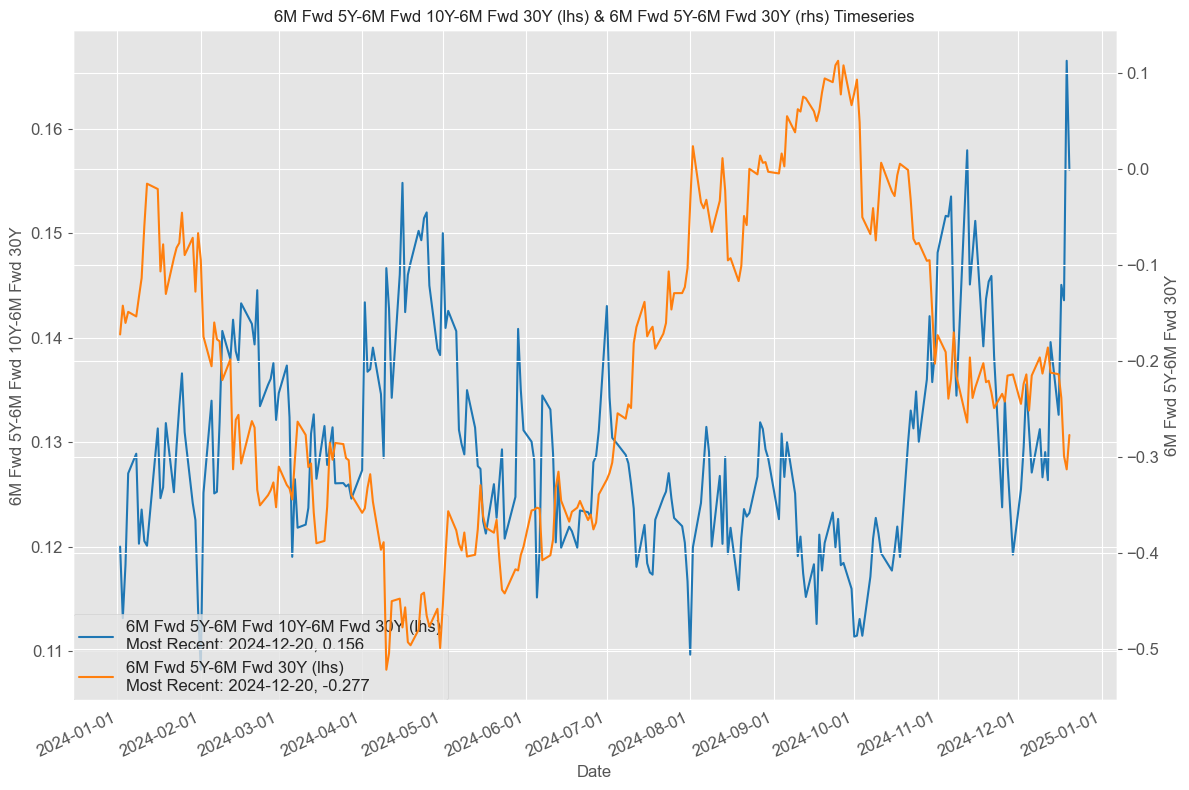

In [137]:
s490_swaps._general_df_plotter(df=timeseries_df, cols_to_plot=["6M Fwd 5Y-6M Fwd 10Y-6M Fwd 30Y"], cols_to_plot_raxis=["6M Fwd 5Y-6M Fwd 30Y"])

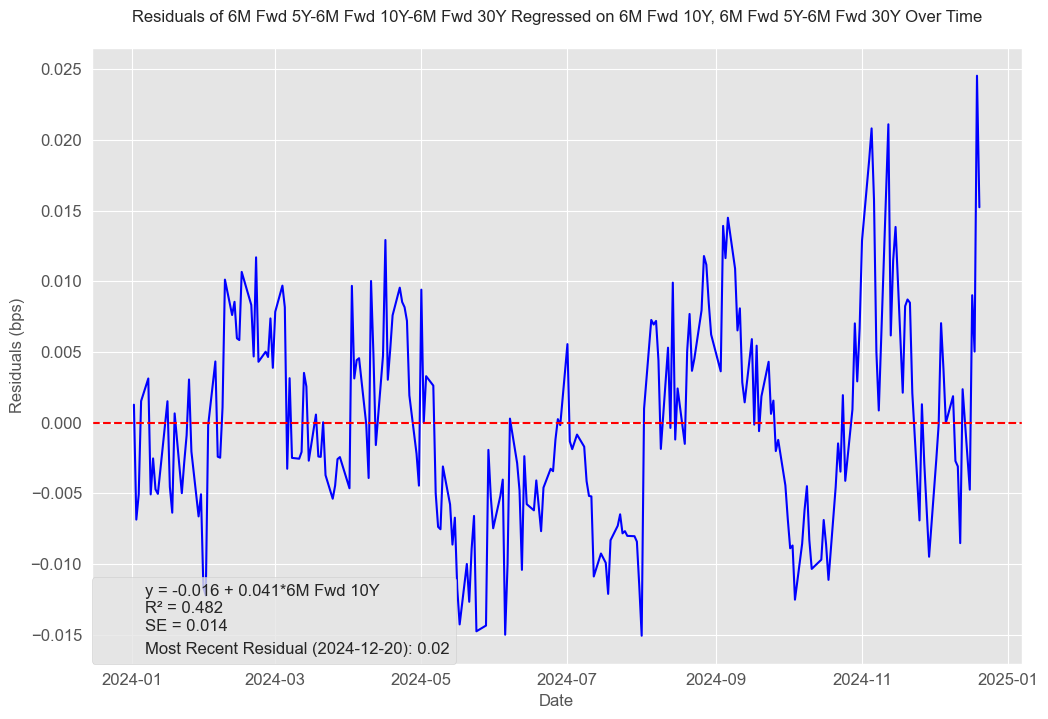

In [139]:
_, convexity_rr = run_multiple_linear_regression_df(
    df=timeseries_df, x_cols=["6M Fwd 10Y", "6M Fwd 5Y-6M Fwd 30Y"], y_col="6M Fwd 5Y-6M Fwd 10Y-6M Fwd 30Y", show_plot=False
)
plot_residuals_timeseries(df=timeseries_df, results=convexity_rr)

In [140]:
_, beta_weights_rr = run_multiple_linear_regression_df(
    df=timeseries_df, x_cols=["6M Fwd 5Y", "6M Fwd 30Y"], y_col="6M Fwd 10Y", show_plot=False, on_diff=True
)
print(beta_weights_rr.summary())

                            OLS Regression Results                            
Dep. Variable:             6M Fwd 10Y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.336e+04
Date:                Thu, 09 Jan 2025   Prob (F-statistic):          8.37e-247
Time:                        12:48:59   Log-Likelihood:                 917.59
No. Observations:                 243   AIC:                            -1829.
Df Residuals:                     240   BIC:                            -1819.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.68e-05      0.000      0.075      0.9

In [148]:
front_wing_beta_adjustment_wrt_belly, back_wing_beta_adjustment_wrt_belly = beta_weights_rr.params.values[1:]
front_wing_beta_adjustment_wrt_belly, back_wing_beta_adjustment_wrt_belly

(np.float64(0.5269906622845781), np.float64(0.5242078123620425))

In [149]:
front_wing_tenor = "6M Fwd 5Y"
belly_tenor = "6M Fwd 10Y"
back_wing_tenor = "6M Fwd 30Y"

hh_swaps.dv01_neutral_butterfly_hedge_ratio(
    front_leg_swap=hh_swaps.SwapLeg(
        original_tenor=front_wing_tenor, original_fixed_rate=timeseries_df[front_wing_tenor].iloc[-1]/100, trade_date=end_date, weighting=-0.5, 
    ),
    belly_swap=hh_swaps.SwapLeg(
        original_tenor=belly_tenor, original_fixed_rate=timeseries_df[belly_tenor].iloc[-1]/100, trade_date=end_date, weighting=1, 
    ),
    back_leg_swap=hh_swaps.SwapLeg(
        original_tenor=back_wing_tenor, original_fixed_rate=timeseries_df[back_wing_tenor].iloc[-1]/100, trade_date=end_date, weighting=-0.5, 
    ),
    ql_curve=ql_curves[end_date],
    ql_yts=s490_swaps._ql_yts,
    ql_sofr=s490_swaps._ql_sofr,
    belly_notional=100_000_000,
    # front_wing_beta_adjustment_wrt_belly=0.5666,
    # back_wing_beta_adjustment_wrt_belly=0.4901,
)


BPV Neutral Hedge Ratio:
{
    "front_wing_hr": -0.9097080301597273,
    "belly_hr": 1,
    "back_wing_hr": -0.23422451444311143
}
6M Fwd 5Y: Fixed Notional = -90_970_803.016, PVBP = -40_091.594
6M Fwd 10Y: Fixed Notional = 100_000_000.000, PVBP = 80_183.189
6M Fwd 30Y: Fixed Notional = -23_422_451.444, PVBP = -40_091.594
Net Fixed Notional: -14_393_254.460
BPV Neutral Fly PVBP: -40_091.594
3M bps Running Carry & Roll: 2.544 bps


{'is_long': np.float64(-1.0),
 'risk_weights': [-0.5, 1, -0.5],
 'current_fly_bps': np.float64(15.608735406927865),
 'current_fly_pvbp': np.float64(-40091.59431024296),
 'bpv_neutral_fly_bps': np.float64(15.608735406927865),
 'bpv_neutral_fly_pvbp': np.float64(-40091.59431024296),
 '1M_carry_and_roll_bps_running': 1.9630287368445352,
 '1M_carry_and_roll_bps_running_beta_weigted': None,
 '2M_carry_and_roll_bps_running': 2.2122041024251473,
 '2M_carry_and_roll_bps_running_beta_weigted': None,
 '3M_carry_and_roll_bps_running': 2.543958698284221,
 '3M_carry_and_roll_bps_running_beta_weigted': None,
 '6M_carry_and_roll_bps_running': 3.6455599218539536,
 '6M_carry_and_roll_bps_running_beta_weigted': None,
 'total_trade_notional': np.float64(-14393254.460283875),
 'front_wing': {'current_yield': np.float64(0.04006765507476584),
  'current_weighted_yield': np.float64(-0.02003382753738292),
  'hr': np.float64(-0.9097080301597273),
  'bpv_hr': np.float64(-0.9097080301597273),
  'notional': np.fl